<a href="https://colab.research.google.com/github/julichitai/learning_NN/blob/tutorials/pytorch_object_detection_PennFudanPed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
data_root = '/content/drive/MyDrive/PennFudanPed'

Custom dataset should inherit from the standard torch.utils.data.Dataset class, and implement \_\_len\_\_ and \_\_getitem\_\_.

In [2]:
import torch
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path
import matplotlib.pyplot as plt


class PennFudanDataset(object):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = sorted([str(i) for i in (Path(root) / 'PNGImages').glob('*.png')])
        self.masks = sorted([str(i) for i in (Path(root) / 'PedMasks').glob('*.png')])

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert('RGB')
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # fig, ax = plt.subplots(1, 2)
        # ax1, ax2 = ax.flatten()
        # ax1.imshow(img)
        # ax2.imshow(mask)
        # plt.show()

        
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            x_min = np.min(pos[1])
            x_max = np.max(pos[1])
            y_min = np.min(pos[0])
            y_max = np.max(pos[0])
            boxes.append([x_min, y_min, x_max, y_max])

        # draw = ImageDraw.Draw(img)
        # draw.rectangle((x_min, y_min, x_max, y_max))
        # plt.imshow(img)
        # plt.show()
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs, ), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.as_tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        is_crowd = torch.zeros((num_objs, ), dtype=torch.int64)
    
        # suppose all instances are not crowd
    

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = is_crowd

        if not self.transforms is None:
            img = self.transforms(img)
        
        return img, target

    def __len__(self):
        return len(self.imgs)


d = PennFudanDataset(data_root, None)
d.__getitem__(1)

(<PIL.Image.Image image mode=RGB size=455x414 at 0x7FDFE0D64400>,
 {'area': tensor([35301.]),
  'boxes': tensor([[ 67.,  92., 190., 379.]]),
  'image_id': tensor([1]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [3]:
dataset = PennFudanDataset(data_root)
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FDFE0D516D8>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In this tutorial, we will be using Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.
<img src='https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png'>

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.
<img src='https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image04.png'>


There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

### 1 - Finetuning from a pretrained model

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchsummary import summary


# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


### 2 - Modifying the model to add a different backbone

In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280
# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ),
                                   aspect_ratios=((0.5, 1.0, 2.0), ))
# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_poller = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone=backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_poller)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [6]:
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, 
                                                      num_classes=num_classes)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # and replace the mask predictor with a new one
    hidden_layers = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask,
                                                       dim_reduced=hidden_layers,
                                                       num_classes=num_classes)
    return model

get_model_instance_segmentation(2)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

## Testing forward() method

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

In [7]:
import torchvision.transforms as transforms


def get_transform(train):
    transformations = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transformations.append(transforms.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.RandomHorizontalFlip(0.5)
    return transforms.Compose(transformations)

In [8]:
get_transform(True)(dataset[0][0])

tensor([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
         [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
         [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
         ...,
         [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
         [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
         [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],

        [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
         [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
         [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
         ...,
         [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
         [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
         [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],

        [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
         [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
         [0.6863, 0.6471, 0.6235,  ..., 0.2549, 0.2588, 0.

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset(data_root, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [11]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 15535 (delta 133), reused 102 (delta 68), pack-reused 15346
Receiving objects: 100% (15535/15535), 16.16 MiB | 8.91 MiB/s, done.
Resolving deltas: 100% (11045/11045), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


Let’s now write the main function which performs the training and the validation:

In [12]:
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])


In [20]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, print_freq=100, header=header):
        print(100)
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [24]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    # our dataset has two classes only - background and person
    num_classes = 2
    batch_size = 2
    learning_rate = 0.005
    num_epoch = 10
    # use our dataset and defined transformations
    dataset = PennFudanDataset(root=data_root,
                               transforms=get_transform(train=True))
    dataset_test = PennFudanDataset(root=data_root,
                                    transforms=get_transform(train=False))
    # split the dataset in train and test set
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset))
    dataset = torch.utils.data.Subset(dataset=dataset,
                                      indices=indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset=dataset_test,
                                           indices=indices[-50:])
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4, 
                                              collate_fn=utils.collate_fn)
    data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                                   batch_size=1,
                                                   shuffle=False,
                                                   num_workers=4, 
                                                   collate_fn=utils.collate_fn)
    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes=num_classes)
    # move model to the right device
    model.to(device)
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params=params, 
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
    # let's train it for 10 epochs
    for epoch in range(num_epoch):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model=model,
                        optimizer=optimizer,
                        data_loader=data_loader,
                        device=device,
                        epoch=epoch,
                        print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        print(len(data_loader_test))
        evaluate(model=model,
                 data_loader=data_loader_test,
                 device=device)
        # evaluate(model, data_loader_test, device=device)

    print("That's it!")
    return model

model = main()

cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:02:06  lr: 0.000090  loss: 4.6462 (4.6462)  loss_classifier: 0.7964 (0.7964)  loss_box_reg: 0.4012 (0.4012)  loss_mask: 3.4269 (3.4269)  loss_objectness: 0.0159 (0.0159)  loss_rpn_box_reg: 0.0058 (0.0058)  time: 2.1065  data: 0.3588  max mem: 6220
Epoch: [0]  [10/60]  eta: 0:01:22  lr: 0.000936  loss: 1.7052 (2.2517)  loss_classifier: 0.4552 (0.4695)  loss_box_reg: 0.3045 (0.2848)  loss_mask: 0.9928 (1.4743)  loss_objectness: 0.0159 (0.0185)  loss_rpn_box_reg: 0.0032 (0.0047)  time: 1.6414  data: 0.0424  max mem: 6774
Epoch: [0]  [20/60]  eta: 0:01:04  lr: 0.001783  loss: 0.9147 (1.5273)  loss_classifier: 0.2073 (0.3279)  loss_box_reg: 0.2175 (0.2567)  loss_mask: 0.3977 (0.9123)  loss_objectness: 0.0186 (0.0228)  loss_rpn_box_reg: 0.0032 (0.0076)  time: 1.5826  data: 0.0103  max mem: 6774
Epoch: [0]  [30/60]  eta: 0:00:47  lr: 0.002629  loss: 0.6230 (1.2212)  loss_classifier: 0.1349 (0.2546)  loss_box_reg: 0.2134 (0.2495)  loss_mask: 0.2178 (0.6892)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [27]:
# pick one image from the test set
img, target = dataset_test[0]
with torch.no_grad():
    # put the model in evaluation mode
    model.eval()
    prediction = model([img.to(device)])

In [83]:
prediction

[{'boxes': tensor([[ 45.5928,  71.0191, 174.7738, 363.2646],
          [200.8672,  73.1251, 303.5904, 331.5533],
          [340.2710,  54.1929, 419.4633, 278.0844],
          [265.6805,  71.2220, 382.4492, 355.7154],
          [210.2118,  83.6034, 418.6845, 316.9147],
          [109.2262,  76.8610, 377.8441, 349.1903],
          [379.5927,  68.9293, 423.1677, 214.7221],
          [ 76.5824,  77.7706, 255.3734, 359.4568],
          [362.9990,  56.7944, 411.1653, 235.1278]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
        

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [85]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [86]:
def get_random_color():
    return (np.random.randint(0, 256),
            np.random.randint(0, 256),
            np.random.randint(0, 256))

In [87]:
from PIL import ImageDraw


def draw_bounding_boxes(img: np.array, prediction: dict)-> None:
    img_pil = Image.fromarray(img_np)
    draw = ImageDraw.Draw(img_pil)

    for bb in prediction[0]['boxes']:
        draw.rectangle(bb.cpu().numpy(), outline=get_random_color(), width=3)

    plt.imshow(img_pil)
    plt.show()

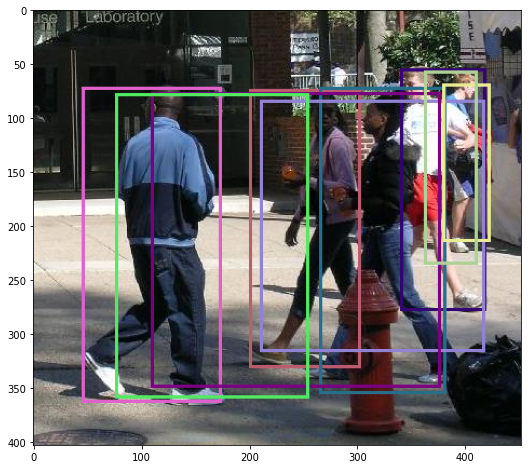

In [88]:
img_np = img.mul(255).permute(1, 2, 0).numpy().astype('uint8')
draw_bounding_boxes(img_np, prediction)

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

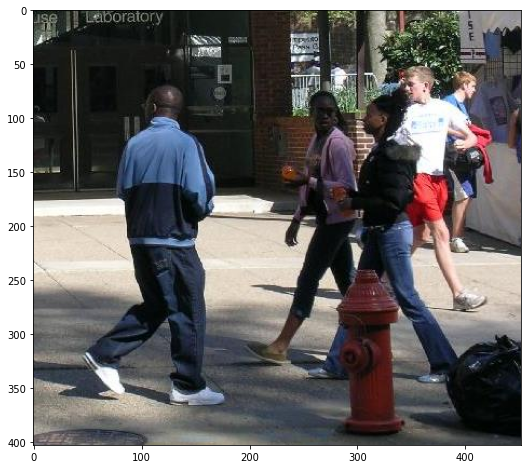

In [115]:
plt.imshow(img_np);

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [126]:
prediction[0]['masks'].shape

torch.Size([9, 1, 403, 452])

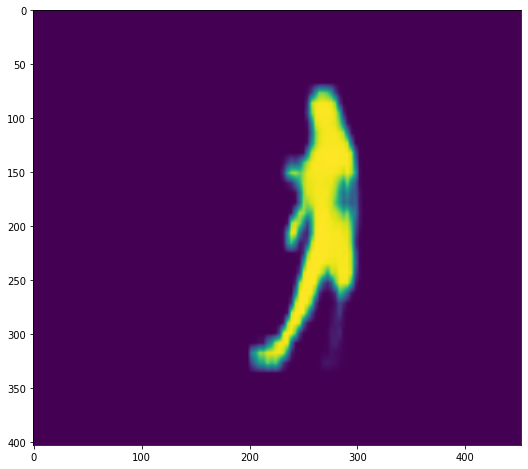

In [127]:
plt.imshow(prediction[0]['masks'][1][0].mul(255).cpu().numpy());

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 

